### Проект: **синхронное распознавание эмоций по видеокадрам и звуковой дорожке**.
Будем искать лицо некого персонажа в кадре и пытаться распознать эмоции на этом лице, одновременно распознавая эмоции в речи этого персонажа (если он что-то говорит). На заключительном этапе добавим еще распознавание эмоций непосредственно по голосу (без преобразование в текст). Получится мультимодальное распознавание эмоций - одновременно по видео, голосу и тексту.

In [ ]:
# Colab: базовые пакеты
!pip -q install ultralytics supervision==0.20.0 opencv-python-headless==4.10.0.84 lapx filterpy deepface==0.0.92

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.2 MB/s eta 0:00:00



Для поиска лица на видео в реальном времени нам нужна связка: детектор лиц и трекер. Будем использовать лёгкий и простой стек (PyTorch/Ultralytics): **YOLOv8n-face + ByteTrack**.

Детектор лиц - находит и локализует все лица на одном кадре (отдельном изображении). Он отвечает на вопрос "Где здесь лица?".

Трекер лиц - следит за уже обнаруженными лицами. Он отвечает на вопрос "Куда переместилось лицо №1 с предыдущего кадра?".


In [ ]:
import os, urllib.request

# Используем модель YOLOv8n-face (загрузка весов)

WEIGHTS_FACE = "/content/yolov8n-face.pt"

def try_download(url: str, dst: str):
    try:
        print(f"Trying: {url}")
        urllib.request.urlretrieve(url, dst)
        print("Downloaded:", dst)
        return True
    except Exception as e:
        print("Failed:", e)
        return False

if not os.path.exists(WEIGHTS_FACE):
    mirrors = [
        "https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt",
        "https://huggingface.co/adamgeitgey/yolov8-face/resolve/main/yolov8n-face.pt",
    ]
    ok = any(try_download(u, WEIGHTS_FACE) for u in mirrors)
    if not ok:
        print("Необходимо загрузить yolov8n-face.pt вручную в /content")
else:
    print("Weights already present:", WEIGHTS_FACE)


Trying: https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt
Downloaded: /content/yolov8n-face.pt


### Для распознавания эмоций будем использовать DeepFace:
https://github.com/serengil/deepface

In [ ]:
# утилиты для распознавания эмоций
import cv2
import numpy as np
from typing import Tuple
from deepface import DeepFace

DF_LABELS = ["angry","disgust","fear","happy","sad","surprise","neutral"]

def square_crop_with_padding(x1,y1,x2,y2, W,H, pad=0.25):
    cx = (x1+x2)/2; cy=(y1+y2)/2
    s = max(x2-x1, y2-y1)
    s = int(s*(1.0+pad))
    nx1 = int(cx - s/2); ny1 = int(cy - s/2)
    nx2 = nx1 + s;      ny2 = ny1 + s
    nx1 = max(0,nx1); ny1 = max(0,ny1)
    nx2 = min(W-1,nx2); ny2 = min(H-1,ny2)
    return nx1,ny1,nx2,ny2

class EmotionDeepFaceWrapper:
    """
    Прямой вызов модели 'Emotion' из DeepFace.
    Препроцесс: BGR -> Gray -> 48x48 -> float32[0..1] -> (1,48,48,1)
    """
    def __init__(self):
        self.model = DeepFace.build_model("Emotion")  # загружается 1 раз
        self.target_size = (48, 48)

    def _preprocess(self, face_bgr: np.ndarray) -> np.ndarray:
        # защита от пустых/малых кропов
        if face_bgr is None or face_bgr.size == 0 or min(face_bgr.shape[:2]) < 20:
            return None
        gray = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2GRAY)
        # более мягкий ресайз для мелких лиц
        interp = cv2.INTER_AREA if (gray.shape[0]*gray.shape[1] > 48*48) else cv2.INTER_LINEAR
        gray = cv2.resize(gray, self.target_size, interpolation=interp)
        x = gray.astype(np.float32) / 255.0
        x = np.expand_dims(x, axis=(0, -1))  # (1,48,48,1)
        return x

    def predict(self, face_bgr) -> Tuple[str, float, np.ndarray]:
        x = self._preprocess(face_bgr)
        if x is None:
            probs = np.array([0,0,0,0,0,0,1], dtype=np.float32)
            return "neutral", float(probs[-1]), probs
        preds = self.model.predict(x, verbose=0)[0].astype(np.float32)  # (7,)
        s = float(preds.sum())
        if s > 1e-6:
            preds /= s
        idx = int(np.argmax(preds))
        return DF_LABELS[idx], float(preds[idx]), preds

def ema_update(prev: np.ndarray | None, cur: np.ndarray, alpha: float) -> np.ndarray:
    if prev is None: return cur
    return alpha * cur + (1.0 - alpha) * prev


25-11-21 21:25:47 - Directory /root/.deepface created
25-11-21 21:25:47 - Directory /root/.deepface/weights created


In [ ]:
# Скачиваем наше исходное видео:

import gdown
# Галя, ты сейчас упадешь!..
#url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1h6PQMcUa8sq_UTFlnIpaiFfMmoeSv7AE'

#Комсомолка и просто красавица!
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1yO5zlUgvz62D9sec6y10LHFfEAAT1xc1'
gdown.download(url, '/content/original_video.mp4')

# Криминальное чтиво
#url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1t8ZSnNlrapj06xB1oCj0FO8U_bDE4Pe-'

#url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1PaCQED1ppAcsZ4qOKaw7Ds8m6K1YDE5p'

# Поттер и Малфой
# https://drive.google.com/file/d/1XJHWSMK47z5yiqXmrn9PiBpZtqW2F30O/view?usp=sharing
# Дьявол носит Prada
#https://drive.google.com/file/d/1PaCQED1ppAcsZ4qOKaw7Ds8m6K1YDE5p/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1yO5zlUgvz62D9sec6y10LHFfEAAT1xc1
To: /content/original_video.mp4
100%|██████████| 2.22M/2.22M [00:00<00:00, 200MB/s]


'/content/original_video.mp4'

In [ ]:
# Подаем в модель DeepFace Emotion BGR-батч (1,H,W,3), без ручного gray/resize
import cv2
import numpy as np
from typing import Tuple
from deepface import DeepFace

DF_LABELS = ["angry","disgust","fear","happy","sad","surprise","neutral"]

def square_crop_with_padding(x1,y1,x2,y2, W,H, pad=0.25):
    cx = (x1+x2)/2; cy=(y1+y2)/2
    s = max(x2-x1, y2-y1)
    s = int(s*(1.0+pad))
    nx1 = int(cx - s/2); ny1 = int(cy - s/2)
    nx2 = nx1 + s;      ny2 = ny1 + s
    nx1 = max(0,nx1); ny1 = max(0,ny1)
    nx2 = min(W-1,nx2); ny2 = min(H-1,ny2)
    return nx1,ny1,nx2,ny2

class EmotionDeepFaceWrapper:
    """
    Подаём в DeepFace Emotion исходный BGR-кроп как батч (1,H,W,3).
    Вся подготовка (GRAY/resize) выполняется внутри EmotionClient.predict().
    """
    def __init__(self):
        self.model = DeepFace.build_model("Emotion")  # загружается один раз

    def predict(self, face_bgr) -> Tuple[str, float, np.ndarray]:
        # защита от пустых/слишком маленьких кропов
        if face_bgr is None or face_bgr.size == 0:
            probs = np.array([0,0,0,0,0,0,1], dtype=np.float32)
            return "neutral", float(probs[-1]), probs
        h, w = face_bgr.shape[:2]
        if h < 20 or w < 20:
            probs = np.array([0,0,0,0,0,0,1], dtype=np.float32)
            return "neutral", float(probs[-1]), probs

        # гарантируем 3 канала (BGR)
        if face_bgr.ndim == 2:
            face_bgr = cv2.cvtColor(face_bgr, cv2.COLOR_GRAY2BGR)
        elif face_bgr.shape[2] == 1:
            face_bgr = cv2.cvtColor(face_bgr, cv2.COLOR_GRAY2BGR)

        # батч 1xHxWx3, dtype uint8
        batch = np.expand_dims(face_bgr.astype(np.uint8), axis=0)

        # Универсальный вызов (в разных версиях это .predict или __call__)
        try:
            out = self.model.predict(batch)
        except TypeError:
            out = self.model(batch)

        # приводим к numpy и форме (7,)
        if isinstance(out, (list, tuple)):
            out = out[0]
        preds = np.asarray(out).reshape(-1).astype(np.float32)

        # нормализуем на всякий случай
        s = float(preds.sum())
        if s > 1e-6:
            preds /= s

        i = int(np.argmax(preds))
        return DF_LABELS[i], float(preds[i]), preds

def ema_update(prev: np.ndarray | None, cur: np.ndarray, alpha: float) -> np.ndarray:
    if prev is None: return cur
    return alpha * cur + (1.0 - alpha) * prev

# Переинициализируй классификатор, если он уже создан ранее:
emo_clf = EmotionDeepFaceWrapper()



25-11-21 21:31:55 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 47.4MB/s]


In [ ]:
# Основной пайплайн: детекция/трекинг лица + распознавание эмоций + сохранение видео/CSV
# Распознавание займет несколько минут

import os, csv, cv2, torch, numpy as np
from ultralytics import YOLO
import supervision as sv

# ---------- вход/выход ----------
VIDEO_IN  = "/content/original_video.mp4"
VIDEO_OUT = "/content/tracked_emotions.mp4"
CSV_OUT   = "/content/tracked_emotions.csv"
assert os.path.exists(VIDEO_IN), f"Не найден входной файл: {VIDEO_IN}"

# ---------- параметры ----------
DEVICE       = 0 if torch.cuda.is_available() else "cpu"
IMG_SIZE     = 640          # на CPU можно 480; на GPU — 896–960
CONF_THRES   = 0.30
IOU_THRES    = 0.50
DETECT_EVERY = 1
EMO_EVERY    = 3            # для CPU реже; на GPU можно 2
MIN_FACE_SZ  = 64
PAD_RATIO    = 0.28         # чуть больше контекста
EMO_EMA_A    = 0.70

# ---------- вспомогательные ----------
def ema_update(prev: np.ndarray|None, cur: np.ndarray, a: float) -> np.ndarray:
    cur = cur.astype(np.float32)
    if prev is None:
        return cur
    return (a * cur + (1.0 - a) * prev).astype(np.float32)

def square_crop_with_padding(x1,y1,x2,y2,W,H,pad=0.0):
    # квадрат с паддингом вокруг бокса, в пределах кадра
    w = max(1, x2 - x1); h = max(1, y2 - y1)
    cx = x1 + w/2.0; cy = y1 + h/2.0
    side = int(max(w, h) * (1.0 + pad))
    nx1 = int(max(0, min(W-1, round(cx - side/2))))
    ny1 = int(max(0, min(H-1, round(cy - side/2))))
    nx2 = int(max(0, min(W,   round(nx1 + side))))
    ny2 = int(max(0, min(H,   round(ny1 + side))))
    # финальная корректировка, чтобы не было вырожденности
    if nx2 <= nx1: nx2 = min(W, nx1 + 1)
    if ny2 <= ny1: ny2 = min(H, ny1 + 1)
    return nx1, ny1, nx2, ny2

# ---------- модели ----------
# YOLOv8n-face
model = YOLO("/content/yolov8n-face.pt").to(DEVICE)

# ByteTrack (новые имена с фолбэком)
try:
    tracker = sv.ByteTrack(
        track_activation_threshold=0.4,
        lost_track_buffer=30,
        minimum_matching_threshold=0.8
    )
except TypeError:
    tracker = sv.ByteTrack(
        track_thresh=0.4,
        track_buffer=30,
        match_thresh=0.8
    )

box_annotator   = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_scale=0.5, text_thickness=1)

# КЛАСС эмоций: предполагается, что он уже определён ранее
# и совместим с 7 метками DeepFace: angry, disgust, fear, happy, sad, surprise, neutral
EMO_LABELS = ["angry","disgust","fear","happy","sad","surprise","neutral"]
emo_clf = EmotionDeepFaceWrapper()  # <-- класс из предыдущих ячеек

# ---------- видео I/O ----------
cap = cv2.VideoCapture(VIDEO_IN)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(VIDEO_OUT, cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))

print(f"Processing: {VIDEO_IN} → {VIDEO_OUT} | {W}x{H}@{fps:.2f} | device={DEVICE}")

# ---------- состояние ----------
emo_ema: dict[int, np.ndarray] = {}
csv_rows = []
frame_idx = 0

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        # Детекция
        if frame_idx % DETECT_EVERY == 0:
            res = model.predict(
                source=frame,
                imgsz=IMG_SIZE,
                conf=CONF_THRES,
                iou=IOU_THRES,
                device=DEVICE,
                verbose=False
            )[0]
            dets = sv.Detections.from_ultralytics(res)
            # YOLOv8n-face имеет один класс лиц → фильтрация по class_id==0 на всякий случай
            if dets.class_id is not None:
                dets = dets[dets.class_id == 0]

            # Отсечь мелкие боксы
            if len(dets) > 0:
                keep = []
                for i,(x1,y1,x2,y2) in enumerate(dets.xyxy.astype(int)):
                    if (x2-x1) >= MIN_FACE_SZ and (y2-y1) >= MIN_FACE_SZ:
                        keep.append(i)
                dets = dets[np.array(keep)] if keep else sv.Detections.empty()

            tracks = tracker.update_with_detections(dets)
        else:
            # без новой детекции — обновляем только трекер, чтобы он "старил" треки
            tracks = tracker.update_with_detections(sv.Detections.empty())

        do_emo = (frame_idx % EMO_EVERY == 0)
        frame_anno = frame.copy()
        labels = []

        # Безопасная итерация: только по тем трекам, где есть tracker_id
        if getattr(tracks, "tracker_id", None) is not None and len(tracks.tracker_id) > 0:
            Hc, Wc = frame.shape[:2]
            for xyxy, tid in zip(tracks.xyxy, tracks.tracker_id):
                if tid is None:
                    continue
                x1, y1, x2, y2 = map(int, xyxy)
                nx1, ny1, nx2, ny2 = square_crop_with_padding(x1, y1, x2, y2, Wc, Hc, PAD_RATIO)

                face = frame[ny1:ny2, nx1:nx2]
                if face is None or face.size == 0:
                    continue

                # Считаем эмоции реже (ускорение)
                if do_emo:
                    try:
                        label, conf, probs = emo_clf.predict(face)  # probs: np.ndarray shape [7]
                        if probs is not None and probs.size == 7:
                            emo_ema[int(tid)] = ema_update(emo_ema.get(int(tid)), probs, EMO_EMA_A)
                    except Exception:
                        # не роняем пайплайн, просто пропускаем этот фрейм
                        pass

                # Сглаженные оценки (если есть)
                probs_s = emo_ema.get(int(tid))
                if probs_s is not None and probs_s.size == 7:
                    e_idx  = int(np.argmax(probs_s))
                    e_lab  = EMO_LABELS[e_idx]
                    e_conf = float(probs_s[e_idx])
                    probs_to_log = probs_s
                else:
                    e_lab, e_conf = "…", 0.0
                    probs_to_log = np.zeros(7, dtype=np.float32)

                labels.append(f"id:{int(tid)} | {e_lab} {e_conf:.2f}")

                # Лог в CSV
                row = {
                    "frame": frame_idx,
                    "time_sec": f"{frame_idx/fps:.3f}",
                    "track_id": int(tid),
                    "x1": nx1, "y1": ny1, "x2": nx2, "y2": ny2,
                    "emotion": e_lab, "confidence": f"{e_conf:.4f}"
                }
                for k, cls in enumerate(EMO_LABELS):
                    row[f"p_{cls}"] = f"{float(probs_to_log[k]):.4f}"
                csv_rows.append(row)

            # Рисуем только найденные треки
            frame_anno = box_annotator.annotate(scene=frame_anno, detections=tracks)
            frame_anno = label_annotator.annotate(scene=frame_anno, detections=tracks, labels=labels)

        # Записываем кадр
        out.write(frame_anno)
        frame_idx += 1

finally:
    cap.release()
    out.release()

# ---------- CSV ----------
cols = ["frame","time_sec","track_id","x1","y1","x2","y2","emotion","confidence"] + \
       [f"p_{c}" for c in EMO_LABELS]
with open(CSV_OUT, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=cols)
    w.writeheader()
    w.writerows(csv_rows)

print("Готово!")
print("Видео:", VIDEO_OUT)
print("CSV  :", CSV_OUT)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Processing: /content/original_video.mp4 → /content/tracked_emotions.mp4 | 646x480@25.00 | device=0


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `B

Готово!
Видео: /content/tracked_emotions.mp4
CSV  : /content/tracked_emotions.csv


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


### Ниже — готовые ячейки для того, чтобы:

- вытащить аудиодорожку из /content/emotions.mp4 в WAV 16 кГц моно;

- распознать русскую речь с тайм-кодами с помощью **faster-whisper**;

- сохранить расшифровку в .txt, .srt и .csv.

In [ ]:
# Аудио и ASR
!pip -q install faster-whisper==1.0.3 webrtcvad==2.0.10
# ffmpeg для извлечения аудио
!apt -yqq install ffmpeg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import os, subprocess, json, textwrap

VIDEO_IN = "/content/original_video.mp4"
AUDIO_WAV = "/content/emotions_16k_mono.wav"

assert os.path.exists(VIDEO_IN), f"Не найден файл: {VIDEO_IN}"

# Извлечём аудио: 16 кГц, моно, PCM16 — оптимально для ASR
cmd = [
    "ffmpeg", "-y",
    "-i", VIDEO_IN,
    "-vn",                # без видео
    "-acodec", "pcm_s16le",
    "-ar", "16000",       # 16 кГц
    "-ac", "1",           # моно
    AUDIO_WAV
]
subprocess.run(cmd, check=True)
print("Аудио извлечено:", AUDIO_WAV)


Аудио извлечено: /content/emotions_16k_mono.wav


In [ ]:
from faster_whisper import WhisperModel
import numpy as np
import csv, math, os

AUDIO_WAV = "/content/emotions_16k_mono.wav"
TXT_OUT   = "/content/emotions_ru_transcript.txt"
SRT_OUT   = "/content/emotions_ru_transcript.srt"
CSV_OUT   = "/content/emotions_ru_segments.csv"

# ── Настройки модели ──────────────────────────────────────────────
# Выбираем размер модели: "small" (быстро), "medium" (качественнее), "large-v3" (максимум качества)
MODEL_SIZE = "medium"  # на CPU можно "small"; на GPU можно "large-v3"

# device / compute_type:
#  - CPU: device="cpu", compute_type="int8" или "int8_float16" / "int8" (скорость)
#  - GPU: device="cuda", compute_type="float16"
import torch
if torch.cuda.is_available():
    DEVICE = "cuda"
    COMPUTE_TYPE = "float16"
else:
    DEVICE = "cpu"
    COMPUTE_TYPE = "int8"

print(f"Модель: {MODEL_SIZE} | device={DEVICE} | compute_type={COMPUTE_TYPE}")

# ── Инициализация модели ─────────────────────────────────────────
model = WhisperModel(MODEL_SIZE, device=DEVICE, compute_type=COMPUTE_TYPE)

# ── Распознавание ────────────────────────────────────────────────
# Параметры:
#  - language="ru": принудительно русский (ускоряет и повышает точность на русском)
#  - vad_filter=True: VAD (требует webrtcvad) — устойчивее к паузам/шумам
#  - word_timestamps=True: слова с таймкодами (полезно позже для синхронизации)
segments, info = model.transcribe(
    AUDIO_WAV,
    language="ru",
    vad_filter=True,
    word_timestamps=True,
    beam_size=5,          # декодер beam-search; снизьте до 1 для скорости
    condition_on_previous_text=True
)

# Соберём сегменты в память
seg_list = []
for seg in segments:
    seg_list.append({
        "start": float(seg.start),
        "end": float(seg.end),
        "text": seg.text.strip(),
        "words": [
            {"start": float(w.start), "end": float(w.end), "word": w.word}
            for w in (seg.words or [])
            if w.start is not None and w.end is not None
        ]
    })

print(f"Сегментов: {len(seg_list)}")

# ── Сохранение в TXT ─────────────────────────────────────────────
with open(TXT_OUT, "w", encoding="utf-8") as f:
    for s in seg_list:
        f.write(s["text"] + "\n")
print("Сохранено TXT:", TXT_OUT)

# ── Сохранение в SRT ─────────────────────────────────────────────
def to_srt_timestamp(t):
    # t в секундах -> "HH:MM:SS,mmm"
    h = int(t // 3600); t -= h*3600
    m = int(t // 60);   t -= m*60
    s = int(t)
    ms = int((t - s) * 1000)
    return f"{h:02d}:{m:02d}:{s:02d},{ms:03d}"

with open(SRT_OUT, "w", encoding="utf-8") as f:
    for i, s in enumerate(seg_list, start=1):
        f.write(f"{i}\n")
        f.write(f"{to_srt_timestamp(s['start'])} --> {to_srt_timestamp(s['end'])}\n")
        f.write(s["text"] + "\n\n")
print("Сохранено SRT:", SRT_OUT)

# ── Сохранение в CSV (суммарные сегменты) ────────────────────────
with open(CSV_OUT, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["idx","start","end","text"])
    w.writeheader()
    for i, s in enumerate(seg_list):
        w.writerow({"idx": i, "start": s["start"], "end": s["end"], "text": s["text"]})
print("Сохранено CSV:", CSV_OUT)


Модель: medium | device=cuda | compute_type=float16


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Сегментов: 4
Сохранено TXT: /content/emotions_ru_transcript.txt
Сохранено SRT: /content/emotions_ru_transcript.srt
Сохранено CSV: /content/emotions_ru_segments.csv


## Теперь нам нужно распознать эмоциональную окраску полученного текста

In [ ]:
!pip uninstall -y torchvision fastai

Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: fastai 2.8.5
Uninstalling fastai-2.8.5:
  Successfully uninstalled fastai-2.8.5


In [ ]:
# СТАВИМ только то, что нужно
!pip install "torch==2.4.0" "transformers==4.44.2" "accelerate>=0.33,<1.0" --no-deps
# добавим необходимые зависимости transformers отдельно
!pip install tokenizers==0.19.1 huggingface_hub>=0.24.0 safetensors>=0.4.0 regex>=2024.0.0 sentencepiece>=0.1.99

### Ниже — ячейки для Google Colab, в которых мы:

- берем расшифровку /content/emotions_ru_segments.csv из предыдущего шага,

- определяем эмоциональную окраску по каждому сегменту,

- сохраняем результаты в CSV и формируем SRT с метками.

Будем использовать модель **ruBERT-сентимент** (blanchefort/rubert-base-cased-sentiment) из Hugging Face

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# попробуем базовую (точнее), если не хватит памяти — tiny2 (быстрее)
candidates = [
    "seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions",
    "seara/rubert-tiny2-russian-emotion-detection-ru-go-emotions",
    "seara/rubert-base-cased-russian-emotion-detection-cedr",
    "cointegrated/rubert-tiny2-cedr-emotion-detection",
    "Djacon/rubert-tiny2-russian-emotion-detection"
]

pipe = None; last_err = None
for m in candidates:
    try:
        tok = AutoTokenizer.from_pretrained(m)
        mdl = AutoModelForSequenceClassification.from_pretrained(m)
        pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, return_all_scores=True)
        active = m
        break
    except Exception as e:
        last_err = e
        continue

assert pipe is not None, f"Не удалось загрузить ни одну модель: {last_err}"

# ТЕСТ
with open("/content/emotions_ru_transcript.txt", encoding="utf-8") as f:
    text = f.read()

#text = "Алло, Анюта, ты себе не представляешь, я сейчас улетаю в Гагры с самим Якиным. Галочка, ты сейчас умрёшь. Потрясающая новость. Якин бросил свою Кикимару, ну и уговорил меня лететь в Гагры."
pred = pipe(text)[0]  # список словарей {label, score}
pred_sorted = sorted(pred, key=lambda x: x["score"], reverse=True)[:5]
pred_sorted


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[{'label': 'admiration', 'score': 0.7527387738227844},
 {'label': 'approval', 'score': 0.11392797529697418},
 {'label': 'neutral', 'score': 0.07789041846990585},
 {'label': 'love', 'score': 0.06807065010070801},
 {'label': 'caring', 'score': 0.030572375282645226}]

In [ ]:
import pandas as pd
import numpy as np
import math

import os
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"   # важно поставить ДО импортов transformers
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
device = "cuda" if torch.cuda.is_available() else "cpu"
device

CSV_IN  = "/content/emotions_ru_segments.csv"
CSV_OUT = "/content/emotions_ru_segments_emotions_model.csv"

# 1) Загружаем одну из русских моделей эмоций (сначала base, при ошибке - tiny)
CANDIDATES = [
    "seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions",   # 28 эмоций (GoEmotions-RU), мультилейбл
    "seara/rubert-tiny2-russian-emotion-detection-ru-go-emotions",        # облегчённая
    "seara/rubert-base-cased-russian-emotion-detection-cedr",             # CEDR (базовые эмоции)
    "cointegrated/rubert-tiny2-cedr-emotion-detection",                   # лёгкая CEDR
    "Djacon/rubert-tiny2-russian-emotion-detection"                       # 9 эмоций + neutral
]

tok = mdl = None
active = None
last_err = None
for m in CANDIDATES:
    try:
        tok = AutoTokenizer.from_pretrained(m)
        mdl = AutoModelForSequenceClassification.from_pretrained(m).to(device)
        active = m
        break
    except Exception as e:
        last_err = e

if mdl is None:
    raise RuntimeError(f"Не удалось загрузить модель эмоций: {last_err}")
id2label = mdl.config.id2label
label_list = [id2label[i] for i in range(len(id2label))]
print("Модель:", active)
print("Классы:", label_list)

# простая эвристика: go-emotions → мультилейбл (sigmoid), иначе softmax
IS_MULTILABEL = "go-emotions" in (active or "").lower()

@torch.no_grad()
def predict_batch(texts, batch_size=16, max_length=256, normalize=False):
    """
    Возвращает список словарей {label: score, ...} для каждого текста.
    Для мультилейбл используем сигмоиды; при normalize=True можно нормировать на сумму 1 (для красоты).
    """
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(
            batch, padding=True, truncation=True, max_length=max_length,
            return_tensors="pt"
        ).to(device)
        logits = mdl(**enc).logits
        probs = torch.sigmoid(logits) if IS_MULTILABEL else torch.softmax(logits, dim=1)
        if IS_MULTILABEL and normalize:
            probs = probs / (probs.sum(dim=1, keepdim=True) + 1e-9)
        probs = probs.detach().cpu().numpy()
        for row in probs:
            out.append({label_list[j]: float(row[j]) for j in range(len(label_list))})
    return out

# 2) Читаем ASR-сегменты
df = pd.read_csv(CSV_IN)
assert {"start","end","text"}.issubset(df.columns), "В CSV нужны столбцы: start, end, text"
texts = df["text"].fillna("").astype(str).tolist()

# 3) Инференс
preds = predict_batch(texts, batch_size=16, max_length=256, normalize=False)

# 4) Записываем вероятности в p_<label>
for lbl in label_list:
    df[f"p_{lbl}"] = [float(p.get(lbl, 0.0)) for p in preds]

# 5) Топ-метка и её скор (по текущей нормировке)
top_labels, top_scores = [], []
for p in preds:
    if not p:
        top_labels.append("neutral"); top_scores.append(0.0)
    else:
        tl, ts = max(p.items(), key=lambda x: x[1])
        top_labels.append(tl); top_scores.append(ts)
df["emo_top"] = top_labels
df["emo_score"] = top_scores

df.to_csv(CSV_OUT, index=False)
print("Готово:", CSV_OUT)
print("Столбцов добавлено:", sum(c.startswith("p_") for c in df.columns))
print(df.head(3))


Модель: seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions
Классы: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Готово: /content/emotions_ru_segments_emotions_model.csv
Столбцов добавлено: 28
   idx  start    end                                               text  \
0    0   0.00   7.37  В честь открытия дворца мы предоставляем прекр...   
1    1   8.82  13.62  которая олисистворяет собой новую судьбу женщи...   
2    2  14.72  20.49            Это студентка, комсомолка, спортсменка.   

   p_admiration  p_amusement   p_anger  p_annoyance  p_approval  p_caring  \
0      0.159020     0.001522  0.006179     0.009845    0.059007  0.207238   
1      0.005645     0.002993  0.020880     0.04727

In [ ]:
df = pd.read_csv(CSV_OUT)
df.head(3)

,idx,start,end,text,p_admiration,p_amusement,p_anger,p_annoyance,p_approval,p_caring,...,p_optimism,p_pride,p_realization,p_relief,p_remorse,p_sadness,p_surprise,p_neutral,emo_top,emo_score
0,0,0.00,7.37,В честь открытия дворца мы предоставляем прекр...,0.159020,0.001522,0.006179,0.009845,0.059007,0.207238,...,0.045652,0.006380,0.010029,0.006533,0.005247,0.009348,0.002965,0.212472,neutral,0.212472
1,1,8.82,13.62,которая олисистворяет собой новую судьбу женщи...,0.005645,0.002993,0.020880,0.047273,0.047718,0.010486,...,0.006471,0.001146,0.019880,0.001444,0.001715,0.016395,0.001666,0.811424,neutral,0.811424
2,2,14.72,20.49,"Это студентка, комсомолка, спортсменка.",0.163419,0.013950,0.012778,0.028194,0.051991,0.004774,...,0.003597,0.002664,0.011615,0.001854,0.001405,0.014206,0.004651,0.595020,neutral,0.595020


### Как теперь объединить («сшить») видео-эмоции и эмоции из текста (речи)?
Самый наглядный артефакт - это **демо-видео**. Мы будем выводить на видео рамку на лице, а рядом подпись. Как пример:
Video: happy 0.78 | Text: admiration 0.42 | Fused: happy 0.71

Цветная лента внизу кадра — «спарклайн» мультимодальной эмоции за последние 2–3 сек.

При начале каждого ASR-сегмента (из SRT) — краткие титры снизу с текстом реплики + топ-3 текстовых эмоций.

Итог: зритель буквально видит, как фраза меняет мультимодальную эмоцию конкретного лица.

### Что делает ячейка:

- берёт рамки лиц и видео-эмоции по кадрам из emotions_tracks_emotions.csv;

- берёт ASR-сегменты и (если есть) текстовые эмоции из /content/emotions_ru_segments_emotions_model.csv (тот CSV мы строили раньше).
‣ если файла с текст-эмоциями нет, она аккуратно работает только на видео-эмоциях (текст → нейтрально).

- на каждый кадр считает Fused = α·Video + (1−α)·Text (по 7 базовым классам);

- рисует: рамку, бейдж Video | Text | Fused, цветную ленту-спарклайн последних 2 секунд, и в момент начала каждой реплики — титры с текстом и топ-3 текст-эмоциями;

- сохраняет видео /content/emotions_demo_fused.mp4.

28 эмоций модели seara/rubert-base-cased-russian-emotion-detection-ru-go-emotions:

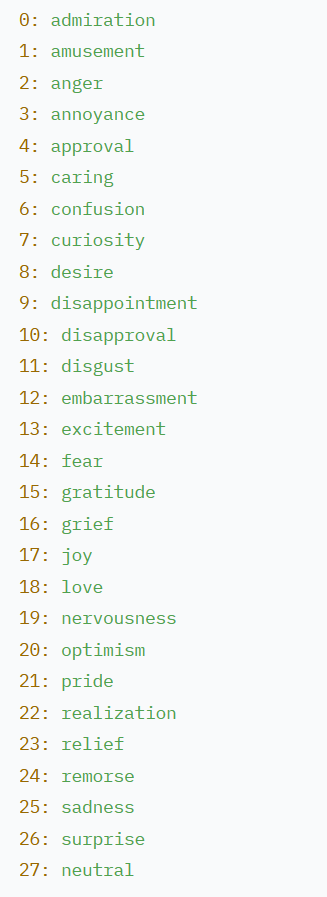

In [ ]:
# === A) ДЕМО-ВИДЕО МУЛЬТИМОДАЛЬНЫХ ЭМОЦИЙ ===
import os, csv, math, cv2, json, numpy as np
import pandas as pd
from collections import deque, defaultdict

# ----- ВХОДНЫЕ ФАЙЛЫ -----
VIDEO_IN   = "/content/original_video.mp4"
TRACK_CSV  = "/content/tracked_emotions.csv"          # из пайплайна видео-эмоций
SEG_ASR    = "/content/emotions_ru_segments.csv"              # ASR сегменты (start,end,text)
SEG_EMO    = "/content/emotions_ru_segments_emotions_model.csv"  # тот же CSV, но с p_<label> текст-эмоций (если есть)

# ----- ВЫХОД -----
VIDEO_OUT  = "/content/emotions_demo_fused.mp4"

assert os.path.exists(VIDEO_IN),  f"Нет видео: {VIDEO_IN}"
assert os.path.exists(TRACK_CSV), f"Нет CSV треков: {TRACK_CSV}"
assert os.path.exists(SEG_ASR),   f"Нет ASR CSV: {SEG_ASR}  (нужны start,end,text)"

# ----- НАСТРОЙКИ ФЬЮЖНА/ОФОРМЛЕНИЯ -----
ALPHA = 0.65                        # вес видео-эмоций в фьюжне
SPARK_WINDOW_SEC = 2.0              # окно истории для ленты
SUBTITLE_SHOW_SEC = 2.5             # сколько секунд держать титры после начала сегмента
FONT = cv2.FONT_HERSHEY_SIMPLEX
PALETTE = {
    "angry":    (36,  36, 255),
    "disgust":  (0,  153, 102),
    "fear":     (160,  64, 160),
    "happy":    (40,  200, 40),
    "sad":      (200, 120, 40),
    "surprise": (40, 200, 200),
    "neutral":  (180, 180, 180),
}
EMO7 = ["angry","disgust","fear","happy","sad","surprise","neutral"]

# ----- ЗАГРУЗКА ДАННЫХ -----
df_tracks = pd.read_csv(TRACK_CSV)
# ожидаем колонки: frame,time_sec,track_id,x1,y1,x2,y2, emotion, confidence, p_angry...p_neutral
need_cols = {"frame","time_sec","track_id","x1","y1","x2","y2"} | {f"p_{e}" for e in EMO7}
miss = need_cols - set(df_tracks.columns)
if miss:
    raise RuntimeError(f"В {TRACK_CSV} не хватает колонок: {sorted(miss)}")

# Аггрегируем «на всякий случай»: если несколько строк на кадр — возьмём самую уверенную
def row_key(r): return float(r.get("confidence", 0))
df_tracks = df_tracks.sort_values(by=["frame", "confidence"], ascending=[True, False]).drop_duplicates(subset=["frame"])

# Индексация по кадру
by_frame = {int(r.frame): r for _, r in df_tracks.iterrows()}

# ASR сегменты
df_asr = pd.read_csv(SEG_ASR)
for col in ["start","end","text"]:
    assert col in df_asr.columns, f"В {SEG_ASR} нет колонки '{col}'"
segments = df_asr[["start","end","text"]].copy()
segments["start"] = segments["start"].astype(float)
segments["end"]   = segments["end"].astype(float)

# Текст-эмоции
text_probs = None
if os.path.exists(SEG_EMO):
    df_te = pd.read_csv(SEG_EMO)
    # подберём доступные метки из GoEmotions-модели и сведём их к 7 классам
    # Маппинг: суммируем релевантные метки в базовые 6, остальное → neutral по остаточному принципу
    # Список кандидатов можно расширять под конкретную модель (seara go-emotions):
    MAP_TO7 = {
        "happy":     {"joy","excitement","contentment","amusement","pride","admiration","approval","gratitude",
                      "love","optimism","relief"},
        "sad":       {"sadness","grief","disappointment","remorse"},
        "angry":     {"anger","annoyance","disapproval"},
        "fear":      {"fear","nervousness"},
        "surprise":  {"surprise","realization","confusion","embarrassment"},
        "disgust":   {"disgust"},
        "neutral":   {"neutral","caring","ciriosity","desire"},
    }

    # найдём какие p_* доступны
    text_labels = [c[2:] for c in df_te.columns if c.startswith("p_")]
    def to7(row):
        vals = {lbl: float(row.get(f"p_{lbl}", 0.0)) for lbl in text_labels}
        out = {e: 0.0 for e in EMO7}
        # распределяем по маппингу
        for e6, srcs in MAP_TO7.items():
            out[e6] = float(sum(vals.get(s, 0.0) for s in srcs))
        # neutral как остаток (если есть нормировка), иначе 0
        s6 = sum(out[e] for e in ["happy","sad","angry","fear","surprise","disgust"])
        out["neutral"] = max(0.0, 1.0 - s6) if s6 <= 1.0 else 0.0
        # нормируем на сумму 1 для удобства
        s_all = sum(out.values()) or 1.0
        for k in out: out[k] = out[k] / s_all
        return out

    # построим список по сегментам
    text_probs = []
    for _, r in df_te.iterrows():
        text_probs.append(to7(r))
else:
    # фолбэк: текст нейтральный
    text_probs = [{"neutral":1.0, "angry":0.0,"disgust":0.0,"fear":0.0,"happy":0.0,"sad":0.0,"surprise":0.0} for _ in range(len(segments))]

# привяжем text_probs к segments
segments = segments.reset_index(drop=True)
segments["emo7"] = text_probs

# утилита: получить индекс сегмента по времени
def seg_index_at(t):
    # двоичный поиск можно, но здесь хватит линейного — сегментов обычно немного
    for i, row in segments.iterrows():
        if row["start"] <= t <= row["end"]:
            return i
    return None

# ----- ОТКРЫТИЕ видео-----
cap = cv2.VideoCapture(VIDEO_IN)
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(VIDEO_OUT, cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))
print(f"Rendering demo: {VIDEO_IN} → {VIDEO_OUT} | {W}x{H}@{fps:.2f}")

spark_hist = deque(maxlen=int(SPARK_WINDOW_SEC * fps))  # храним последние топ-метки fused
last_seg_shown = None
subtitle_until = -1.0  # время до которого показывать титры
subtitle_cache = ""    # текст титров
subtitle_top3  = ""    # топ-3 текст-эмоций

frame_idx = 0
while True:
    ok, frame = cap.read()
    if not ok: break
    t = frame_idx / fps

    # --- ВИДЕО-ЭМОЦИИ для кадра ---
    if frame_idx in by_frame:
        r = by_frame[frame_idx]
        # бокс
        x1,y1,x2,y2 = int(r.x1), int(r.y1), int(r.x2), int(r.y2)
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,180,255), 2)

        p_video = np.array([float(r[f"p_{e}"]) for e in EMO7], dtype=np.float32)
    else:
        p_video = np.array([0,0,0,0,0,0,1], dtype=np.float32)  # нейтральность

    # --- ТЕКСТ-ЭМОЦИИ для текущего времени ---
    si = seg_index_at(t)
    if si is not None:
        p_text_d = segments.loc[si, "emo7"]
        p_text = np.array([float(p_text_d.get(e, 0.0)) for e in EMO7], dtype=np.float32)
    else:
        p_text = np.array([0,0,0,0,0,0,1], dtype=np.float32)

    # --- ФЬЮЖН ---
    fused = (ALPHA * p_video + (1.0 - ALPHA) * p_text).astype(np.float32)
    fused = fused / (fused.sum() + 1e-9)
    top_idx = int(np.argmax(fused))
    top_lbl = EMO7[top_idx]
    top_scr = float(fused[top_idx])

    # --- бейдж с цифрами ---
    vid_top = EMO7[int(np.argmax(p_video))]
    txt_top = EMO7[int(np.argmax(p_text))]
    badge = f"Video: {vid_top} {p_video.max():.2f} | Text: {txt_top} {p_text.max():.2f} | Fused: {top_lbl} {top_scr:.2f}"
    cv2.rectangle(frame, (10, 10), (10+8*len(badge), 34), (0,0,0), -1)
    cv2.putText(frame, badge, (14, 30), FONT, 0.6, (255,255,255), 1, cv2.LINE_AA)

    # --- начало сегмента? показать титр с текстом и топ-3 текст-эмоциями ---
    if si is not None:
        st = float(segments.loc[si, "start"])
        if last_seg_shown != si and abs(t - st) <= (1.0 / fps) * 1.5:
            last_seg_shown = si
            subtitle_until = t + SUBTITLE_SHOW_SEC
            subtitle_cache = segments.loc[si, "text"]
            # топ-3 текст эмоций
            td = segments.loc[si, "emo7"]
            items = sorted(td.items(), key=lambda x: x[1], reverse=True)[:3]
            subtitle_top3 = " | ".join([f"{k}:{v:.2f}" for k,v in items if v > 0])

    if t <= subtitle_until:
        # плашка внизу
        pad = 8
        blk_h = 60
        cv2.rectangle(frame, (0, H-blk_h-2*pad), (W, H), (0,0,0), -1)
        # сам текст
        cv2.putText(frame, subtitle_cache, (12, H-blk_h+20), FONT, 0.7, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(frame, subtitle_top3,  (12, H-12),        FONT, 0.6, (200,200,200), 1, cv2.LINE_AA)

    # --- СПАРКЛАЙН: цветная лента последних 2 сек (по fused top) ---
    spark_hist.append(top_lbl)
    bar_h = 8
    bar_y1 = H - bar_h - 2
    bar_y2 = H - 2
    # фон
    cv2.rectangle(frame, (0, bar_y1), (W, bar_y2), (30,30,30), -1)
    # рисуем историю от правого края обратно
    maxlen = spark_hist.maxlen or 1
    n = min(len(spark_hist), int(SPARK_WINDOW_SEC * fps))
    if n > 0:
        px_per_step = max(1, int(W / (SPARK_WINDOW_SEC * fps)))
        x = W - 1
        for lbl in reversed(list(spark_hist)[-n:]):
            color = PALETTE.get(lbl, (180,180,180))
            cv2.rectangle(frame, (x - px_per_step + 1, bar_y1), (x, bar_y2), color, -1)
            x -= px_per_step
            if x < 0: break

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print("Готово! DEMO:", VIDEO_OUT)


Rendering demo: /content/original_video.mp4 → /content/emotions_demo_fused.mp4 | 646x480@25.00
Готово! DEMO: /content/emotions_demo_fused.mp4


In [ ]:
SEG_EMO_IN  = "/content/emotions_ru_segments_emotions_model.csv"   # исходный CSV с p_<label> (GoEmotions-RU)
SEG_EMO_OUT = "/content/emotions_ru_segments_emotions_7.csv"

df_te = pd.read_csv(SEG_EMO_IN)

# какие эмоции вообще есть в файле
text_labels = [c[2:] for c in df_te.columns if c.startswith("p_")]
print("Найдено текстовых меток:", len(text_labels))
print("Примеры:", text_labels[:10])

def row_to_7(row):
    # соберём значения для всех исходных меток
    vals = {lbl: float(row.get(f"p_{lbl}", 0.0)) for lbl in text_labels}
    out  = {e: 0.0 for e in EMO7}

    # суммируем по группам
    for e6, srcs in MAP_TO7.items():
        out[e6] = float(sum(vals.get(s, 0.0) for s in srcs))

    # neutral как остаток, если сумма ≤ 1, иначе 0
    s6 = sum(out[e] for e in ["happy","sad","angry","fear","surprise","disgust"])
    out["neutral"] = max(0.0, 1.0 - s6) if s6 <= 1.0 else 0.0

    # нормировка на сумму 1
    s_all = sum(out.values()) or 1.0
    for k in out:
        out[k] /= s_all

    return [out[e] for e in EMO7]

# считаем матрицу (N,7)
mat_7 = np.vstack(df_te.apply(row_to_7, axis=1).values)

# добавляем новые колонки p_angry..p_neutral
for i, e in enumerate(EMO7):
    df_te[f"p_{e}"] = mat_7[:, i]

# можно при желании выбросить старые p_***, оставив только 7 базовых:
# old_p = [c for c in df_te.columns if c.startswith("p_") and c[2:] not in EMO7]
# df_te = df_te.drop(columns=old_p)

df_te.to_csv(SEG_EMO_OUT, index=False, encoding="utf-8")
print("Готово! Сохранён файл с 7 эмоциями:", SEG_EMO_OUT)

Найдено текстовых меток: 28
Примеры: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment']
Готово! Сохранён файл с 7 эмоциями: /content/emotions_ru_segments_emotions_7.csv


In [ ]:
# Добавляем звук из исходного видео обратно в fused-видео
IN_VIDEO = "/content/original_video.mp4"          # исходное видео
FUSED_VIDEO = "/content/emotions_demo_fused.mp4"  # без звука
OUT_VIDEO = "/content/emotions_tracked_fused_audio.mp4"

!ffmpeg -y -i "{FUSED_VIDEO}" -i "{IN_VIDEO}" -c:v copy -c:a aac -map 0:v:0 -map 1:a:0 "{OUT_VIDEO}"

print("Готово! Итоговое видео со звуком сохранено по пути:", OUT_VIDEO)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

###  Ниже мы строим PNG (и по желанию — интерактивный HTML) со сводным таймлайном:

- сверху — Heatmap текстовых эмоций (ASR, приведённых к 7 базовым);

- по центру — полосы по каждому track_id с цветными участками Fused и тонкой линией уверенности;

- снизу — Heatmap видео-эмоций;

- флажки-подписи в моментах начала реплик (кусочек текста + топ-3).

**Входы:**
- emotions_tracks_emotions.csv,
- emotions_ru_segments.csv,
- emotions_ru_segments_emotions_model.csv,
- исходное видео для длины (или берём FPS и длину из трек-csv).

In [ ]:
# Сводный таймлайн - PNG/HTML-график

# %%
import os, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    import cv2
except Exception:
    cv2 = None  # если нет opencv, возьмём FPS/длину из CSV

# ── входы
VIDEO_IN   = "/content/original_video.mp4"                    # опционально, для точного FPS/длины
TRACK_CSV  = "/content/tracked_emotions.csv"                  # трек + p_angry..p_neutral по кадрам
SEG_ASR    = "/content/emotions_ru_segments.csv"                      # start, end, text
SEG_EMO    = "/content/emotions_ru_segments_emotions_model.csv"       # p_<label> для текста (если есть)

# ── выходы
PNG_OUT    = "/content/emotions_timeline_fixed.png"
HTML_OUT   = "/content/emotions_timeline_fixed.html"                  # опционально

# ── базовые 7 классов и палитра (RGB для matplotlib)
EMO7 = ["angry","disgust","fear","happy","sad","surprise","neutral"]
PALETTE_RGB = {
    "angry":    (255/255,  36/255,  36/255),
    "disgust":  (102/255, 153/255,   0/255),
    "fear":     (160/255,  64/255, 160/255),
    "happy":    ( 40/255, 200/255,  40/255),
    "sad":      ( 40/255, 120/255, 200/255),
    "surprise": ( 40/255, 200/255, 200/255),
    "neutral":  (180/255,180/255, 180/255),
}

# ── сведение GoEmotions→7 базовых
MAP_TO7 = {
    "happy":     {"joy","excitement","contentment","amusement","pride","admiration","approval","gratitude","love","optimism","relief","caring","ciriosity","desire"},
    "sad":       {"sadness","grief","disappointment","remorse"},
    "angry":     {"anger","annoyance","disapproval"},
    "fear":      {"fear","nervousness"},
    "surprise":  {"surprise","realization","confusion"},
    "disgust":   {"disgust"},
    "neutral":   {"neutral","caring","ciriosity","desire"},
}

# ── параметры фьюжна
ALPHA = 0.65  # вес видео в Fused (0..1)

In [ ]:
# %%
# треки (видео-эмоции по кадрам)
df_tracks = pd.read_csv(TRACK_CSV)
need_cols = {"frame","time_sec","track_id","x1","y1","x2","y2"} | {f"p_{e}" for e in EMO7}
missing = need_cols - set(df_tracks.columns)
if missing:
    raise RuntimeError(f"В {TRACK_CSV} не хватает колонок: {sorted(missing)}")

# берём по одному лучшему (максимальная confidence) на кадр → виртуальный единый трек
df_tracks = df_tracks.sort_values(["frame","confidence"], ascending=[True, False]).drop_duplicates(["frame"])
best_by_frame = {int(r.frame): r for _, r in df_tracks.iterrows()}

# ── FPS/длительность
if cv2 is not None and os.path.exists(VIDEO_IN):
    cap = cv2.VideoCapture(VIDEO_IN)
    FPS = cap.get(cv2.CAP_PROP_FPS) or 25.0
    frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or (df_tracks["frame"].max()+1))
    DURATION = frames_total / FPS
    cap.release()
else:
    FPS = 25.0
    if len(df_tracks):
        DURATION = float(df_tracks["time_sec"].max())
        frames_total = int(round(DURATION * FPS)) + 1
    else:
        DURATION, frames_total = 0.0, 0

T = max(frames_total, int(math.ceil(DURATION * FPS)))

# ── 2) ASR-сегменты
df_asr = pd.read_csv(SEG_ASR)
assert {"start","end","text"}.issubset(df_asr.columns), "В ASR CSV нужны: start,end,text"
df_asr = df_asr[["start","end","text"]].astype({"start":float,"end":float,"text":str}).reset_index(drop=True)

# ── 3) текст-эмоции по сегментам → приводим к 7 классам
def te_row_to_emo7(row: pd.Series, labels_all: list[str]) -> dict:
    vals = {lbl: float(row.get(f"p_{lbl}", 0.0)) for lbl in labels_all}
    out = {e:0.0 for e in EMO7}
    for e6, src in MAP_TO7.items():
        out[e6] = float(sum(vals.get(s, 0.0) for s in src))
    s6 = sum(out[e] for e in ["happy","sad","angry","fear","surprise","disgust"])
    out["neutral"] = max(0.0, 1.0 - s6) if s6 <= 1.0 else 0.0
    s_all = sum(out.values()) or 1.0
    for k in out: out[k] /= s_all
    return out

if os.path.exists(SEG_EMO):
    df_te = pd.read_csv(SEG_EMO)
    te_labels = [c[2:] for c in df_te.columns if c.startswith("p_")]
    emo7_list = [te_row_to_emo7(row, te_labels) for _, row in df_te.iterrows()]
    df_asr["emo7"] = emo7_list
else:
    neutral7 = {"neutral":1.0, **{e:0.0 for e in EMO7 if e!="neutral"}}
    df_asr["emo7"] = [neutral7.copy() for _ in range(len(df_asr))]

# ── 4) дискретизация текстовой линейки на кадры
text_timeline = np.zeros((T, len(EMO7)), dtype=np.float32)
for _, s in df_asr.iterrows():
    v = np.array([float(s["emo7"].get(e, 0.0)) for e in EMO7], dtype=np.float32)
    t0 = max(0, int(math.floor(s["start"]*FPS)))
    t1 = min(T, int(math.ceil(s["end"]*FPS)))
    if t1 > t0:
        text_timeline[t0:t1, :] = v[None,:]

neutral = np.zeros((len(EMO7),), dtype=np.float32)
neutral[EMO7.index("neutral")] = 1.0
mask_empty = (text_timeline.sum(axis=1) <= 1e-9)
text_timeline[mask_empty, :] = neutral[None, :]

# ── 5) строим один «виртуальный» трек: video_mat, fused_mat, conf_vec
def neutral_vec():
    v = np.zeros((len(EMO7),), dtype=np.float32); v[-1] = 1.0  # ...0001 = neutral
    return v

video_mat = np.zeros((T, len(EMO7)), dtype=np.float32)
fused_mat = np.zeros((T, len(EMO7)), dtype=np.float32)
conf_vec  = np.zeros((T,), dtype=np.float32)

for f in range(T):
    # видео-эмоции
    if f in best_by_frame:
        r = best_by_frame[f]
        v = np.array([float(r[f"p_{e}"]) for e in EMO7], dtype=np.float32)
        if float(v.sum()) <= 1e-9:
            v = neutral_vec()
    else:
        v = neutral_vec()
    video_mat[f,:] = v

    # текст-эмоции в кадре
    t = text_timeline[f,:]
    if float(t.sum()) <= 1e-9:
        t = neutral_vec()

    # фьюжн
    fused = ALPHA * v + (1.0 - ALPHA) * t
    s = float(fused.sum())
    fused = (fused / s) if s > 1e-9 else neutral_vec()
    fused_mat[f,:] = fused
    conf_vec[f] = float(fused.max())

print(f"Матрицы готовы: T={T}, FPS={FPS:.2f}, DURATION≈{T/FPS:.2f}s")



Матрицы готовы: T=631, FPS=25.00, DURATION≈25.24s


In [ ]:
# %%
def emo_index_to_color(idx: int):
    return PALETTE_RGB[EMO7[idx]]

def argmax_to_rgb_row(argmax_row: np.ndarray):
    out = np.zeros((len(argmax_row), 3), dtype=np.float32)
    for i, k in enumerate(argmax_row):
        out[i,:] = emo_index_to_color(int(k))
    return out

# фигура: 3 панели
fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(16, 6.5),
    gridspec_kw={"height_ratios":[0.9, 1.2, 0.9]},
    constrained_layout=True
)

# ── верх: TEXT heatmap
ax_text = axes[0]
text_idx = np.argmax(text_timeline, axis=1) if T>0 else np.array([])
text_rgb = argmax_to_rgb_row(text_idx)[None, :, :] if T>0 else np.zeros((1,1,3))
ax_text.imshow(text_rgb, aspect="auto")
ax_text.set_title("Текстовые эмоции (ASR → 7 базовых)", fontsize=12)
ax_text.set_yticks([]); ax_text.set_xlim([0, max(1,T)])

# флажки/подписи в начале реплик
for _, s in df_asr.iterrows():
    t0 = max(0, int(round(float(s["start"])*FPS)))
    if 0 <= t0 < T:
        ax_text.axvline(t0, color=(1,1,1), linewidth=0.5, alpha=0.6)
        snippet = (s["text"] or "").strip().replace("\n"," ")
        if len(snippet) > 60: snippet = snippet[:57] + "…"
        td = s["emo7"]; top3 = sorted(td.items(), key=lambda x: x[1], reverse=True)[:3]
        emo_str = ", ".join([f"{k}:{v:.2f}" for k,v in top3 if v>0])
        ax_text.text(t0+3, 0.15, snippet, color="white", fontsize=9, va="center", ha="left",
                     bbox=dict(facecolor="black", alpha=0.4, boxstyle="round,pad=0.2"))
        ax_text.text(t0+3, 0.75, emo_str, color="#dddddd", fontsize=8, va="center", ha="left",
                     bbox=dict(facecolor="black", alpha=0.2, boxstyle="round,pad=0.2"))

# ── центр: один ряд Fused + уверенность
ax_fused = axes[1]
fused_idx = np.argmax(fused_mat, axis=1) if T>0 else np.array([])
fused_rgb = argmax_to_rgb_row(fused_idx)[None, :, :] if T>0 else np.zeros((1,1,3))
ax_fused.imshow(fused_rgb, aspect="auto")
ax_fused.set_yticks([]); ax_fused.set_xlim([0, max(1,T)])
ax_fused.set_ylabel("Track 1", rotation=0, labelpad=40, va="center", fontsize=10)
ax_fused.set_title("Мультимодальные эмоции (Fused) + уверенность", fontsize=11)

ax2 = ax_fused.twinx()
ax2.plot(np.arange(T), conf_vec, linewidth=1.0)
ax2.set_ylim(0,1); ax2.set_yticks([0,0.5,1]); ax2.grid(False)

# ── низ: VIDEO heatmap (виртуальный трек)
ax_vid = axes[2]
video_idx = np.argmax(video_mat, axis=1) if T>0 else np.array([])
video_rgb = argmax_to_rgb_row(video_idx)[None, :, :] if T>0 else np.zeros((1,1,3))
ax_vid.imshow(video_rgb, aspect="auto")
ax_vid.set_title("Видео-эмоции (виртуальный трек)", fontsize=12)
ax_vid.set_yticks([]); ax_vid.set_xlim([0, max(1,T)])

# ось X → секунды на нижней панели
xticks = np.linspace(0, max(1,T), 11, dtype=int)
ax_vid.set_xticks(xticks)
sec_labels = [f"{x/max(1,FPS):.0f}s" for x in xticks]
ax_vid.set_xticklabels(sec_labels)

# легенда
legend_patches = [Line2D([0],[0], color=PALETTE_RGB[e], lw=6, label=e) for e in EMO7]
fig.legend(handles=legend_patches, loc="upper right", ncol=1, frameon=False)

plt.savefig(PNG_OUT, dpi=160)
plt.close(fig)
print("PNG сохранён:", PNG_OUT)


PNG сохранён: /content/emotions_timeline_fixed.png


In [ ]:
# %%
!pip -q install plotly

import plotly.graph_objects as go

T = fused_mat.shape[0]
fused_all = fused_mat  # уже один ряд
fused_idx = np.argmax(fused_all, axis=1) if T>0 else np.array([])
fused_lbl = [EMO7[i] for i in fused_idx]

colors = [f"rgb({int(255*r)},{int(255*g)},{int(255*b)})" for (r,g,b) in [PALETTE_RGB[l] for l in fused_lbl]]

fig2 = go.Figure()
fig2.add_bar(
    x=np.arange(T)/max(1.0, float(FPS)), y=[1]*T,
    marker_color=colors, width=1.0/max(1.0, float(FPS)),
    hovertext=[f"{i/max(1.0,FPS):.2f}s → {lbl}" for i,lbl in enumerate(fused_lbl)],
    hoverinfo="text",
)
fig2.update_yaxes(visible=False)
fig2.update_xaxes(title="Time (s)")
fig2.update_layout(height=220, margin=dict(l=20,r=20,t=20,b=40), showlegend=False)

fig2.write_html(HTML_OUT, include_plotlyjs="cdn")
print("HTML сохранён:", HTML_OUT)


HTML сохранён: /content/emotions_timeline_fixed.html


In [ ]:
# Удаляем старые версии
!pip -q uninstall -y torchaudio torchvision torch

# Ставим согласованные версии (CPU). Если у нас GPU, то нужно поменять index-url на cu121.
!pip -q install --no-cache-dir \
  torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
  --index-url https://download.pytorch.org/whl/cpu

# На всякий случай: если в рабочей папке лежат файлы/папки "torchaudio" / "torchvision",
# они могут затенять пакеты. Переименуем.
import os, shutil
for name in ("torchaudio", "torchvision"):
    if os.path.isdir(f"/content/{name}"):
        shutil.move(f"/content/{name}", f"/content/{name}_shadow")
    if os.path.isfile(f"/content/{name}.py"):
        shutil.move(f"/content/{name}.py", f"/content/{name}_shadow.py")

# Перезапуск среды
import IPython
IPython.Application.instance().kernel.do_shutdown(restart=True)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 MB 245.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 314.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 240.6 MB/s eta 0:00:00


{'status': 'ok', 'restart': True}

### **У нас есть один нюанс**.
Иногда на видео эмоции видны очень ярко, а по тексту звуковой дорожки этого не скажешь - довольно часто речь персонажа на видео распознается как нейтральная по эмоциональной окраске и это все ломает.

Можно определять эмоции непосредственно по звуковой дорожке без перевода ее в текст. Для этого будем использовать модель **GigaAM-Emo** от **Сбер**: https://github.com/salute-developers/GigaAM

In [ ]:
!git clone --depth 1 https://github.com/salute-developers/GigaAM.git /content/GigaAM
%cd /content/GigaAM
!pip -q install -e .  # ставим пакет gigaam

Cloning into '/content/GigaAM'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 1), reused 21 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 701.25 KiB | 16.31 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/GigaAM
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 135.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Быстрая инференс-оценка эмоций на всём аудио

import gigaam, json
from pprint import pprint

model = gigaam.load_model("emo")  # GigaAM-Emo
emo_probs = model.get_probs("/content/emotions_16k_mono.wav")  # dict: {emotion: prob}

# Отсортируем по вероятности и выведем топ-5
top = sorted(emo_probs.items(), key=lambda x: x[1], reverse=True)[:5]
print("— Топ-эмоций по всей дорожке —")
for k, v in top:
    print(f"{k:12s}: {v:.3f}")


100%|███████████████████████████████████████| 462M/462M [00:05<00:00, 90.7MiB/s]


— Топ-эмоций по всей дорожке —
positive    : 0.891
angry       : 0.093
neutral     : 0.016
sad         : 0.000


In [ ]:
# Таймлайн эмоций по голосу (скользящее окно)

# Псевдо-онлайн разметка: окно 2.0 c, шаг 0.5 c
# Для простоты сохраняем кусочки во временные WAV и вызываем model.get_probs на файл
import os, math, tempfile, librosa, soundfile as sf
import numpy as np
import pandas as pd

WAV_IN = "/content/emotions_16k_mono.wav"
y, sr = librosa.load(WAV_IN, sr=16000, mono=True)

win_s = 2.0   # сек
hop_s = 0.5   # сек
win_n = int(win_s * sr)
hop_n = int(hop_s * sr)
T = len(y)
frames = []

for start in range(0, T - win_n + 1, hop_n):
    end = start + win_n
    chunk = y[start:end]

    # пишем во временный wav
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        sf.write(tmp.name, chunk, sr, subtype="PCM_16")
        probs = model.get_probs(tmp.name)
        os.unlink(tmp.name)

    t_mid = (start + end) / 2 / sr  # середина окна, сек
    row = {"time_sec": t_mid}
    row.update(probs)
    frames.append(row)

df_emo = pd.DataFrame(frames).sort_values("time_sec").reset_index(drop=True)
print(df_emo.head(8))
df_emo.to_csv("/content/emotions_voice_timeline.csv", index=False, encoding="utf-8")
print("Сохранено: /content/emotions_voice_timeline.csv")


   time_sec     angry       sad   neutral  positive
0       1.0  0.000132  0.000063  0.001772  0.998034
1       1.5  0.004273  0.000112  0.115999  0.879616
2       2.0  0.084902  0.000199  0.072515  0.842385
3       2.5  0.892908  0.000337  0.050501  0.056255
4       3.0  0.717787  0.000299  0.047989  0.233925
5       3.5  0.875092  0.000270  0.044014  0.080624
6       4.0  0.947889  0.000459  0.025732  0.025920
7       4.5  0.000399  0.000251  0.009580  0.989770
Сохранено: /content/emotions_voice_timeline.csv


In [ ]:
df = pd.read_csv("/content/emotions_voice_timeline.csv")
df.head(10)

,time_sec,angry,sad,neutral,positive
0,1.0,0.000132,0.000063,0.001772,0.998034
1,1.5,0.004273,0.000112,0.115999,0.879616
2,2.0,0.084902,0.000199,0.072515,0.842385
3,2.5,0.892908,0.000337,0.050501,0.056255
4,3.0,0.717787,0.000299,0.047989,0.233925
5,3.5,0.875092,0.000270,0.044014,0.080624
6,4.0,0.947889,0.000459,0.025732,0.025920
7,4.5,0.000399,0.000251,0.009580,0.989770
8,5.0,0.002721,0.000129,0.010216,0.986934
9,5.5,0.000496,0.000159,0.008152,0.991193


In [ ]:
# Ячейка, которая берёт три CSV (video/voice/text) и строит единый таймлайн с этими весами и легендой.

# === Мультимодальный таймлайн (Видео + Голос + Текст) → PNG ===
# Входы
VIDEO_TRACK_CSV = "/content/tracked_emotions.csv"            # из видео-пайплайна (p_angry..p_neutral по кадру)
VOICE_CSV       = "/content/emotions_voice_timeline.csv"             # из GigaAM-Emo (time_sec + вероятности)
TEXT_SEG_CSV    = "/content/emotions_ru_segments_emotions_model.csv" # ASR-сегменты с p_<label> (GoEmotions-RU)
VIDEO_IN        = "/content/original_video.mp4"                             # опционально, для точного FPS/длины

# Выход
PNG_OUT = "/content/emotions_multimodal_timeline.png"

# Веса (проценты → доли)
W_VIDEO, W_VOICE, W_TEXT = 0.50, 0.35, 0.15

# ------------------------------------------------------------
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    import cv2
except Exception:
    cv2 = None

# База эмоций (7)
EMO7 = ["angry","disgust","fear","happy","sad","surprise","neutral"]
PALETTE = {
    "angry":    (255/255,  36/255,  36/255),
    "disgust":  (102/255, 153/255,   0/255),
    "fear":     (160/255,  64/255, 160/255),
    "happy":    ( 40/255, 200/255,  40/255),
    "sad":      ( 40/255, 120/255, 200/255),
    "surprise": ( 40/255, 200/255, 200/255),
    "neutral":  (180/255,180/255, 180/255),
}

# Маппинг GoEmotions → 7 (для текстовых p_*)
MAP_TO7 = {
    "happy":     {"joy","excitement","contentment","amusement","pride","admiration","approval","gratitude","love","optimism","relief"},
    "sad":       {"sadness","grief","disappointment","remorse"},
    "angry":     {"anger","annoyance","disapproval"},
    "fear":      {"fear","nervousness"},
    "surprise":  {"surprise","realization","confusion"},
    "disgust":   {"disgust"},
    "neutral":   {"neutral","caring","ciriosity","desire"},
}

# Унификация имён из VOICE_CSV (GigaAM-Emo) → 7 базовых
NAME_NORM = {
    "angry": "angry",          # оставляем как есть
    "sad": "sad",              # оставляем как есть
    "neutral": "neutral",      # оставляем как есть
    "positive": "happy",       # positive → happy
}

def neutral_vec(n=len(EMO7)):
    v = np.zeros((n,), dtype=np.float32); v[-1] = 1.0
    return v

def norm_row(v):
    s = float(np.sum(v))
    return (v / s) if s > 1e-9 else neutral_vec(len(v))

def to_rgb_row(idx_row):
    out = np.zeros((len(idx_row),3), dtype=np.float32)
    for i,k in enumerate(idx_row):
        out[i,:] = PALETTE[EMO7[int(k)]]
    return out

# ---------- 1) Видео: покадровая матрица ----------
df_v = pd.read_csv(VIDEO_TRACK_CSV)
need_cols = {"frame","time_sec"} | {f"p_{e}" for e in EMO7}
missing = need_cols - set(df_v.columns)
if missing:
    raise RuntimeError(f"В {VIDEO_TRACK_CSV} нет колонок: {sorted(missing)}")

# FPS/длина
if cv2 is not None and os.path.exists(VIDEO_IN):
    cap = cv2.VideoCapture(VIDEO_IN)
    FPS = cap.get(cv2.CAP_PROP_FPS) or 25.0
    frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or (df_v["frame"].max()+1))
    cap.release()
else:
    FPS = 25.0
    frames_total = int(df_v["frame"].max()) + 1

T = max(frames_total, 1)

vid_mat = np.zeros((T, len(EMO7)), dtype=np.float32)
for _, r in df_v.iterrows():
    f = int(r["frame"])
    if 0 <= f < T:
        v = np.array([float(r[f"p_{e}"]) for e in EMO7], dtype=np.float32)
        vid_mat[f,:] = norm_row(v)

# ---------- 2) Голос: нормализация меток (positive→happy) + ресемплинг ----------
df_voice = pd.read_csv(VOICE_CSV)
assert "time_sec" in df_voice.columns, f"В {VOICE_CSV} нет 'time_sec'"

orig_cols = [c for c in df_voice.columns if c != "time_sec"]
norm_cols = [c.strip().lower() for c in orig_cols]

acc = {e: np.zeros((len(df_voice),), dtype=np.float32) for e in EMO7}
for raw, norm in zip(orig_cols, norm_cols):
    base = NAME_NORM.get(norm, None)
    if base in EMO7:
        acc[base] += df_voice[raw].astype(float).values

df_voice7 = pd.DataFrame({"time_sec": df_voice["time_sec"].astype(float)})
for e in EMO7:
    df_voice7[f"p_{e}"] = acc[e]

probs = df_voice7[[f"p_{e}" for e in EMO7]].values.astype(np.float32)
row_sums = probs.sum(axis=1, keepdims=True)
neutral = neutral_vec(len(EMO7))
mask_empty = (row_sums <= 1e-9).flatten()
probs[~mask_empty] = probs[~mask_empty] / row_sums[~mask_empty]
probs[mask_empty]  = neutral
df_voice7[[f"p_{e}" for e in EMO7]] = probs

# ресемплинг на кадры «ближайшим» временем
grid = pd.DataFrame({"frame": np.arange(T, dtype=int)})
grid["time_sec"] = grid["frame"] / float(FPS)
df_voice7 = df_voice7.sort_values("time_sec").reset_index(drop=True)
grid = grid.sort_values("time_sec").reset_index(drop=True)
df_voice_on_frames = pd.merge_asof(grid, df_voice7, on="time_sec", direction="nearest").fillna(0.0)

voice_mat = df_voice_on_frames[[f"p_{e}" for e in EMO7]].values.astype(np.float32)
row_sums = voice_mat.sum(axis=1, keepdims=True)
mask_empty = (row_sums <= 1e-9).flatten()
voice_mat[~mask_empty] = voice_mat[~mask_empty] / row_sums[~mask_empty]
voice_mat[mask_empty]  = neutral

# ---------- 3) Текст: сегменты → покадровая матрица ----------
df_text = pd.read_csv(TEXT_SEG_CSV)
assert {"start","end"}.issubset(df_text.columns), f"В {TEXT_SEG_CSV} нужны колонки start,end (+ p_* эмоции)"
txt_labels = [c[2:] for c in df_text.columns if c.startswith("p_")]

def text_row_to7(row):
    vals = {lbl: float(row.get(f"p_{lbl}", 0.0)) for lbl in txt_labels}
    out = {e:0.0 for e in EMO7}
    for e6, src in MAP_TO7.items():
        out[e6] = float(sum(vals.get(s, 0.0) for s in src))
    s6 = sum(out[e] for e in ["happy","sad","angry","fear","surprise","disgust"])
    out["neutral"] = max(0.0, 1.0 - s6) if s6 <= 1.0 else 0.0
    s_all = sum(out.values()) or 1.0
    for k in out: out[k] /= s_all
    return np.array([out[e] for e in EMO7], dtype=np.float32)

text_mat = np.zeros((T, len(EMO7)), dtype=np.float32)
for _, s in df_text.iterrows():
    v = text_row_to7(s)
    t0 = max(0, int(math.floor(float(s["start"])*FPS)))
    t1 = min(T, int(math.ceil(float(s["end"])*FPS)))
    if t1 > t0:
        text_mat[t0:t1,:] = v[None,:]
# на кадрах без сегмента — neutral
empty_mask = (text_mat.sum(axis=1) <= 1e-9)
text_mat[empty_mask,:] = neutral

# ---------- 4) Слияние и визуализация ----------
fused_mat = (W_VIDEO * vid_mat) + (W_VOICE * voice_mat) + (W_TEXT * text_mat)
# нормировка построчно
for i in range(T):
    fused_mat[i,:] = norm_row(fused_mat[i,:])
conf_fused = fused_mat.max(axis=1)

# Рендер (4 панели)
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(16, 8.0),
    gridspec_kw={"height_ratios":[0.9, 0.9, 0.9, 1.2]},
    constrained_layout=True
)

def draw_band(ax, mat, title):
    idx = np.argmax(mat, axis=1) if mat.shape[0] else np.array([])
    rgb = to_rgb_row(idx)[None, :, :] if mat.shape[0] else np.zeros((1,1,3))
    ax.imshow(rgb, aspect="auto")
    ax.set_title(title, fontsize=12)
    ax.set_yticks([]); ax.set_xlim([0, max(1, mat.shape[0])])

draw_band(axes[0], text_mat,  "Текстовые эмоции (ASR→7)")
draw_band(axes[1], voice_mat, "Эмоции по голосу (GigaAM-Emo)")
draw_band(axes[2], vid_mat,   "Эмоции по видео (YOLOv8n-face + FER)")

idx_f = np.argmax(fused_mat, axis=1)
rgb_f = to_rgb_row(idx_f)[None, :, :]
axes[3].imshow(rgb_f, aspect="auto")
axes[3].set_title(f"FUSED — веса: видео {int(W_VIDEO*100)}% | голос {int(W_VOICE*100)}% | текст {int(W_TEXT*100)}%", fontsize=12)
axes[3].set_yticks([]); axes[3].set_xlim([0, max(1, T)])

# Линия уверенности
ax2 = axes[3].twinx()
ax2.plot(np.arange(T), conf_fused, linewidth=1.0)
ax2.set_ylim(0,1); ax2.set_yticks([0,0.5,1]); ax2.grid(False)

# Подписи X в секундах
xt = np.linspace(0, max(1,T), 11, dtype=int)
for ax in axes:
    ax.set_xticks(xt)
axes[-1].set_xticklabels([f"{x/max(1.0,float(FPS)):.0f}s" for x in xt])
axes[-1].set_xlabel("Время (сек)")

# Легенда
legend = [Line2D([0],[0], color=PALETTE[e], lw=6, label=e) for e in EMO7]
fig.legend(handles=legend, loc="upper right", ncol=1, frameon=False)

plt.savefig(PNG_OUT, dpi=160)
plt.close(fig)
print("Готово:", PNG_OUT)

Готово: /content/emotions_multimodal_timeline.png
